In [2]:
import pandas as pd
import requests
from datetime import datetime
import numpy as np
import json
import wget # pip install wget

In [3]:
zephyr_username = "AstonUniversity"
zephyr_password = "Xo08R83d43e0Kk6"

In [4]:
url = "https://data.earthsense.co.uk/zephyrsForUser/%s/%s" % (zephyr_username, zephyr_password)
response = requests.get(url)

In [5]:
print(response.status_code)

200


In [6]:
def jprint(obj):
    # create a formatted string of the Python JSON object
    zepyhr_id = json.dumps(obj, sort_keys=True, indent=4)
    return zepyhr_id

In [7]:
pass_times = response.json()['usersZephyrs']['13883']['zNumber']
jprint(pass_times)

'814'

In [8]:
jsonObject = response.json()['usersZephyrs']
zephyr_id_list = []

for key in jsonObject:
    pass_times = response.json()['usersZephyrs'][key]['zNumber']
    zephyr_id_list.append(jprint(pass_times))
    
print(zephyr_id_list)

['814', '821']


# Download and extraction 

In [9]:
start_datetime = "202108180000"
end_datetime = "202108200000"
slots = "B"
format_output = "csv"
target = "api"

In [10]:
for zephyr_id in zephyr_id_list:
    url = "https://data.earthsense.co.uk/dataForViewBySlots/%s/%s/%s/%s/%s/%s/def/%s/%s" % (zephyr_username, zephyr_password, zephyr_id,start_datetime,end_datetime,slots,format_output,target)

    #We can use the wget library to download the zip file.
    #We can then extract the file into a local "data" folder 
    #The final step is to identify the paths of the csv files we need.
    try: 
        target = wget.download(url, "..\data\zephyrs")
    except BaseException as error:
        print('An exception occurred: {}'.format(error))

An exception occurred: HTTP Error 500: INTERNAL SERVER ERROR
An exception occurred: HTTP Error 500: INTERNAL SERVER ERROR


In [51]:
zephyr_csv = []

for zephyr_id in zephyr_id_list:
    url = "https://data.earthsense.co.uk/dataForViewBySlots/%s/%s/%s/%s/%s/%s/def/%s/%s" % (zephyr_username, zephyr_password, zephyr_id,start_datetime,end_datetime,slots,format_output,target)
    response = requests.get(url)
    if response.status_code == 200:
        zephyr_jsons.append(response.json()['slotB'])
    else:
        print("HTTP request error code: " + response.status_code)

# json to dt

In [153]:
#extracting and preparing the dataframe from the json objects
dfList = []
for jsonObject in zephyr_jsons:
    df_temp = pd.DataFrame.from_records(jsonObject)
    df_temp.drop('header', axis =0, inplace=True)
    df_temp.drop('data_hash', axis =0, inplace=True)
    df_temp.drop('UTS', axis=1, inplace=True)

    #explode function transform each element of a list to a row.
    #we can apply it to all the columns assuming they have the same number of elements in each list 
    df_temp = df_temp.apply(pd.Series.explode)
    
    dfList.append(df_temp)

measurement_dictionary = {k:v for k,v in zip(zephyr_id_list,dfList)}
dfList = [] # clear dataframe list


# Splitting dataframe into days

In [154]:
def dataSplit(df_temp,dateString):
    
    data = {} #intialise empty dictionary to store each day of locations
    
    df_temp = measurement_dictionary[key]

    # using the dates which are already supplied. This strategy in the line below converts them and rounds down to date using 'd' flag
    # This strategy (line below) will keep just the date
    df_temp['day'] = pd.to_datetime(df_temp[dateString], dayfirst=True, errors='coerce').dt.date

    the_unique_dates = df_temp['day'].unique()
    #print('Unique dates:',the_unique_dates)
    # this gives the same result as the for loop below
    
    #splitting the dataframe into separate days
    #for each day in unique dates set:
    for day in the_unique_dates:
        try:
            # In my code below I assign the subset of records to a new dataframe called dft
            # create 'midnight' timestamps
            timestampKey = int((pd.to_datetime(day, errors='coerce')).timestamp())

            # select the records for this day
            dft = df_temp[df_temp['day']==day]

            # #drop the date column to save space (we don't need this anymore)
            #dft = dft.drop(dateString, axis=1)
            dft = dft.drop("day", axis=1)
            dft = dft.dropna() #drop null values
            
            data[timestampKey] = dft

        except KeyError as e:
            print(e)

    return data

In [155]:
for key in measurement_dictionary:
    measurement_dictionary[key] = dataSplit(measurement_dictionary[key],'dateTime')

location_dictionary = measurement_dictionary 

# Separating each list 

In [156]:
def calculateTimestamps(df):
    #set the index to Timestamp and automatically drops the datetime index
    df['Timestamp'] = df.index.values.astype(np.int64) // 10 ** 9
    df.set_index('Timestamp',inplace=True)
    return df

In [157]:
def dataframeAverages(intervalString,df):
    #convert all column types to int
    df = df.astype(int)
    #resample by minute and get mean
    df= df.resample(intervalString).mean() 

    df.isnull().sum() # identify any null values
    df.dropna(inplace=True) #drop null values
    #df = df.astype(int)  #convert avergaes back to int
    return df

In [158]:
for key in measurement_dictionary:
    for timestamp in measurement_dictionary[key]:
        df_temp = measurement_dictionary[key][timestamp]
        df_temp.set_index('dateTime',inplace=True)
        df_temp.index = pd.to_datetime(df_temp.index,dayfirst=True)

        #extracting the location data
        ldf = df_temp[['latitude','longitude']]
        df_temp.drop(['latitude','longitude'],axis=1, inplace=True) #drop the lcoation columns 

        #calculate minute averages
        #df_temp = dataframeAverages('1min',df_temp)
        #df_temp = calculateTimestamps(df_temp)

        #reassign new location dataframe to dictionary
        location_dictionary[key][timestamp] = ldf

        #reassign new measurement dataframe to dictionary
        measurement_dictionary[key][timestamp] = df_temp

In [159]:
for key in measurement_dictionary:
    for timestamp in measurement_dictionary[key]:
        df_temp = measurement_dictionary[key][timestamp]
    #break

df_temp.head()

,NO,NO2,O3,ambHumidity,ambPressure,ambTempC,humidity,particulatePM1,particulatePM10,particulatePM25,tempC
dateTime,,,,,,,,,,,
2021-08-19 00:00:16+00:00,0,11,10,51,99948,22,52,1,8,8,23
2021-08-19 00:00:26+00:00,0,12,8,51,99946,22,52,1,8,8,23
2021-08-19 00:00:36+00:00,0,11,8,51,99946,22,52,1,8,8,23
2021-08-19 00:00:46+00:00,0,12,22,51,99944,22,52,1,8,8,23
2021-08-19 00:00:56+00:00,0,10,10,51,99946,22,52,1,8,8,23


# looking at the data

In [160]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import numpy as np
import matplotlib.dates as mdates

In [162]:
df.head()

,NO,NO2,O3,ambHumidity,ambPressure,ambTempC,humidity,particulatePM1,particulatePM10,particulatePM25,tempC
dateTime,,,,,,,,,,,
2021-08-19 00:00:00+00:00,0.0,9.557994,11.363636,50.959248,99924.373041,22.0,51.984326,0.880878,8.407524,8.407524,22.990596
2021-08-19 01:00:00+00:00,0.0,8.510638,12.714286,50.957447,99898.629179,22.0,51.699088,0.829787,8.553191,8.553191,22.127660
2021-08-19 02:00:00+00:00,0.0,7.403727,12.307453,50.546584,99875.841615,22.0,51.000000,0.754658,8.590062,8.590062,22.000000
2021-08-19 03:00:00+00:00,0.0,8.080997,11.638629,50.373832,99857.186916,22.0,51.000000,0.669782,8.404984,8.404984,22.000000
2021-08-19 04:00:00+00:00,0.0,9.561350,11.131902,50.861963,99833.917178,22.0,51.208589,0.794479,8.674847,8.674847,22.000000


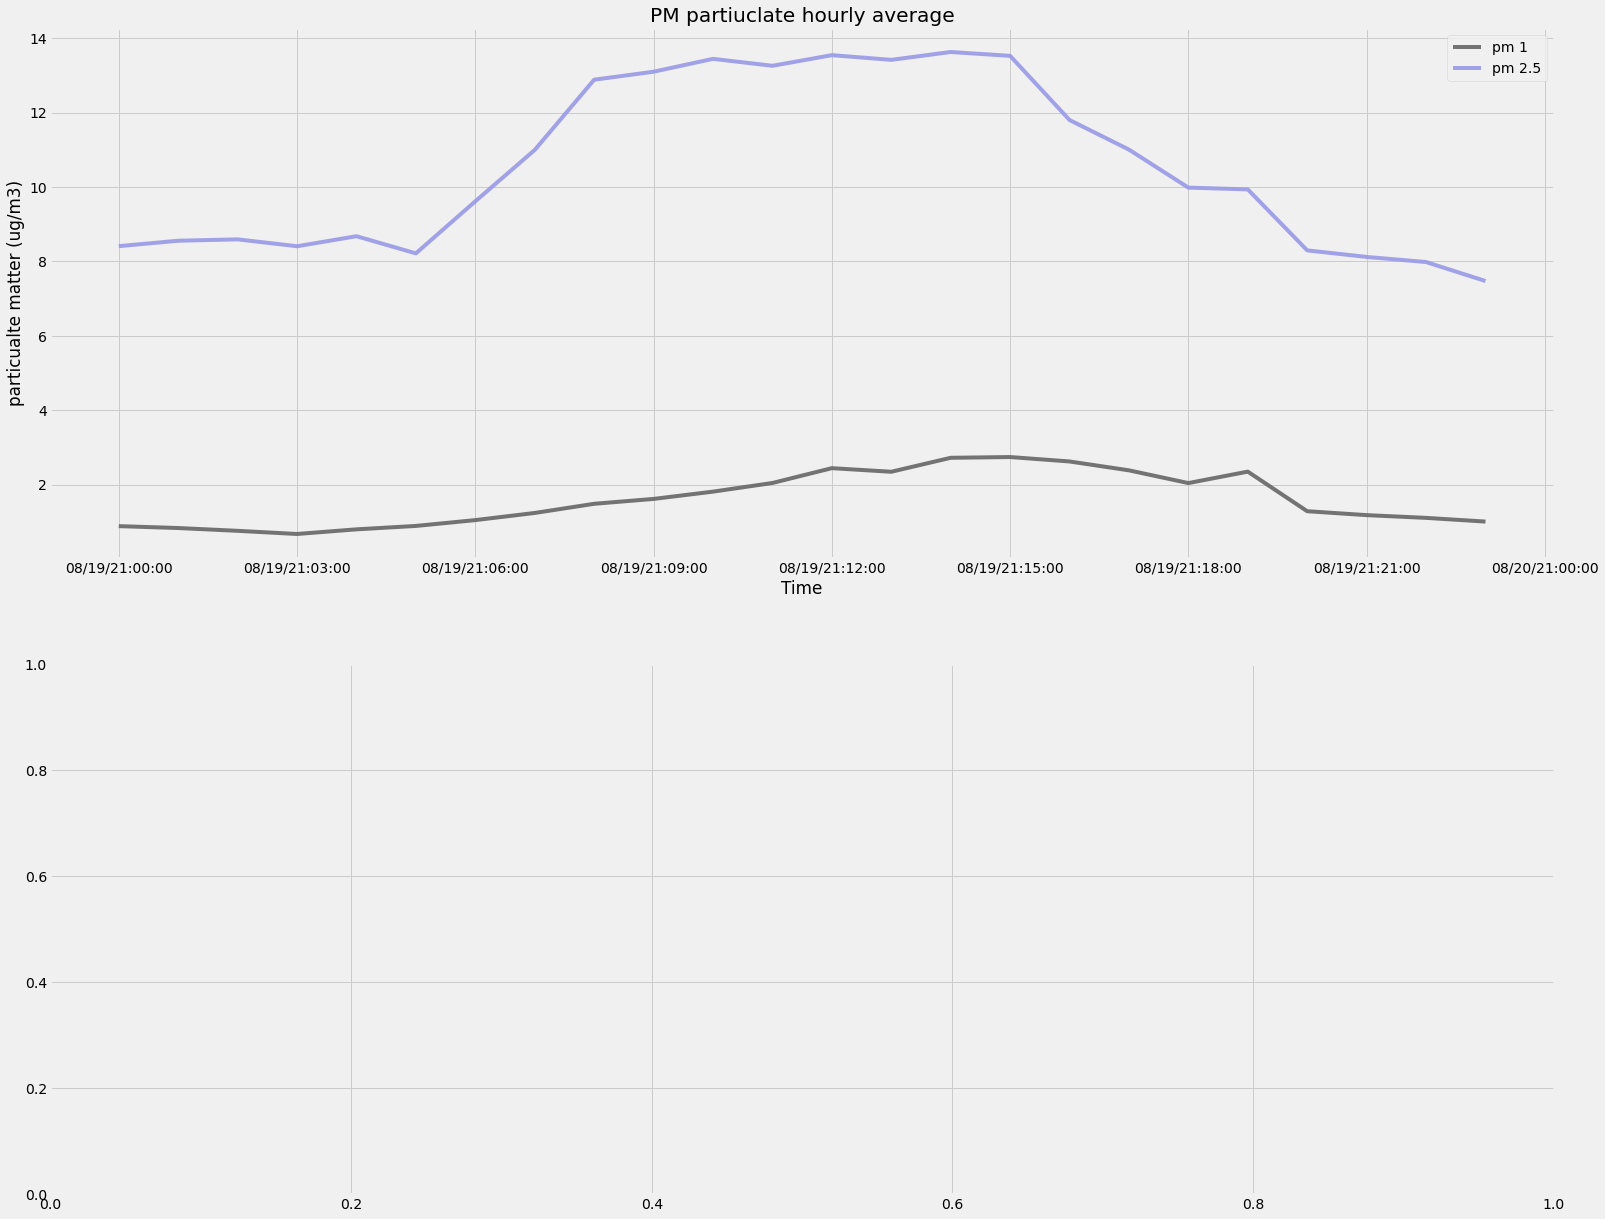

In [161]:
df = dataframeAverages('60min',df_temp)

myTimeFormat = mdates.DateFormatter('%D:%H:%M')

plt.style.use('fivethirtyeight')
fig = plt.figure(figsize = (24,20))
axs = fig.add_suplot(111)

axs.set_title('PM partiuclate hourly average')
axs.plot(df.index, df["particulatePM1"], color = (0.4,0.4,0.4), linewidth = 4, alpha = .9, label = 'pm 1')
axs.plot(df.index, df["particulatePM25"], color = (0.6,0.6,0.9), linewidth = 4, alpha = .9, label = 'pm 2.5')
#axs.plot(df.index, df["particulatePM10"], color = (0.9,0.6,0.6), linewidth = 4, alpha = .9, label = 'pm 10')
axs.set_xlabel("Time")
axs.set_ylabel("particualte matter (ug/m3)")
axs.xaxis.set_major_formatter(myTimeFormat)
axs.legend()

plt.show()

# locations

In [ ]:
def calculateSensorMovement(ldf):
    precision = 0.00025 #this precision constant is derived from the GPS min and max readings which have 0.0003+/- variance for a stationary sensor 

    full_location_storage = False

    #check if the sensor has moved greater than a speicifed precision. 
    if ((ldf['latitude'].min() + precision) > ldf['latitude'].max()) or ((ldf['latitude'].max() - precision) < ldf['latitude'].min()):
        full_location_storage = True
    elif ((ldf['longitude'].min() + precision) > ldf['longitude'].max()) or ((ldf['longitude'].max() - precision) < ldf['longitude'].min()):
        full_location_storage = True
    else:
        full_location_storage = False

    return full_location_storage

In [ ]:
def calculateBoundingBox(ldf):
    min_y= ldf['longitude'].min()
    max_y = ldf['longitude'].max()

    min_x= ldf['latitude'].min()
    max_x = ldf['latitude'].max()
    geometry_string = "POLYGON(({} {}, {} {}, {} {}, {} {},{} {}))".format(min_x,min_y,   min_x,max_y,   max_x,max_y,   max_x,min_y,   min_x,min_y)

In [ ]:
data = {}
hoursummary = []

ldf = ldf.resample('60min').agg(['min','max']) #resample only works with datetimes
ldf['Timestamp'] = ldf.index.values.astype(np.int64) // 10 ** 9
ldf.set_index('Timestamp',inplace=True)

    #extracting a bounding box from hourly readings
try:
    for row in ldf.iterrows():
        geometry_string = ""

        tempArray = [] 
        min_x= row[1][0]    # lat
        max_x = row[1][1]   # lat
                
        min_y= row[1][2]    # long
        max_y = row[1][3]   # long

        geometry_string = "POLYGON(({} {}, {} {}, {} {}, {} {},{} {}))".format(min_x,min_y,   min_x,max_y,   max_x,max_y,   max_x,min_y,   min_x,min_y)

        tempArray = [geometry_string,len(ldf.index.values)] #inserting row into temp array
    hoursummary.append(tempArray)

except Exception as e:
    print('The dataframe is empty therefore no bounding box will be applied :{0}'.format(e))

In [ ]:
print(hoursummary[0])
#ldf.head()